# MHD tests

## Imports

In [8]:
# %pip install ../

import os

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # second gpu

# numerics
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state2D

from jf1uids import get_registered_variables


## Initiatization

In [ ]:
from jf1uids.option_classes.simulation_config import BACKWARDS, FORWARDS, HLL, HLLC, MINMOD, OSHER, PERIODIC_BOUNDARY, BoundarySettings, BoundarySettings1D

print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0
num_cells = 512

fixed_timestep = False
scale_time = False
dt_max = 0.1
num_timesteps = 10

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    progress_bar = True,
    first_order_fallback = False,
    mhd = True,
    dimensionality = 2,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    num_timesteps = num_timesteps,
    limiter = MINMOD,
    riemann_solver = HLL,
    boundary_settings = BoundarySettings(BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY))
)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 0.5,
    C_cfl = 0.4
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the initial state

In [10]:
from jax.random import PRNGKey, uniform

from jf1uids.fluid_equations.fluid import construct_primitive_state2D_mhd
from jf1uids.option_classes.simulation_config import finalize_config

# Set the random seed for reproducibility
key = PRNGKey(0)

# Grid size and configuration
num_cells = config.num_cells
x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# Initialize state
rho = jnp.ones_like(X) * gamma ** 2 / (4 * jnp.pi)
P = jnp.ones_like(X) * gamma / (4 * jnp.pi)

V_x = -jnp.sin(2 * jnp.pi * Y)
V_y = jnp.sin(2 * jnp.pi * X)
V_z = jnp.zeros_like(X)

B_0 = 1 / jnp.sqrt(4 * jnp.pi)
B_x = -B_0 * jnp.sin(2 * jnp.pi * Y)
B_y = B_0 * jnp.sin(4 * jnp.pi * X)
# B_x = jnp.zeros_like(X)
# B_y = jnp.zeros_like(X)
B_z = jnp.zeros_like(X)

initial_magnetic_field = jnp.stack([B_x, B_y, B_z], axis=0)

dx = 1 / (num_cells - 1)

initial_state = construct_primitive_state2D_mhd(rho, V_x, V_y, B_x, B_y, B_z, P, registered_variables)

config = finalize_config(config, initial_state.shape)

## Simulation

In [11]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

## Visualization

### Cut

Text(0.5, 1.0, 'Density')

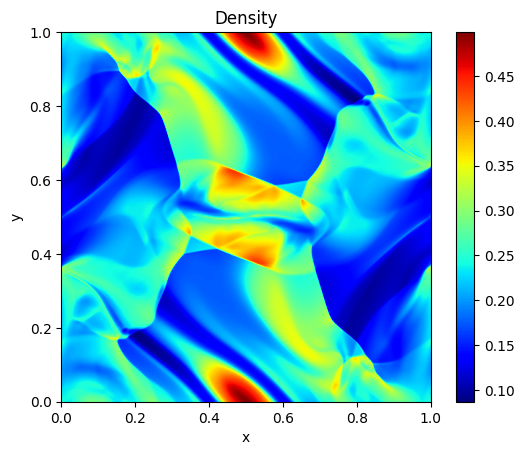

In [12]:
plt.imshow(final_state[0, ...].T, cmap = "jet", origin = "lower", extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Density")

Text(0, 0.5, 'Pressure')

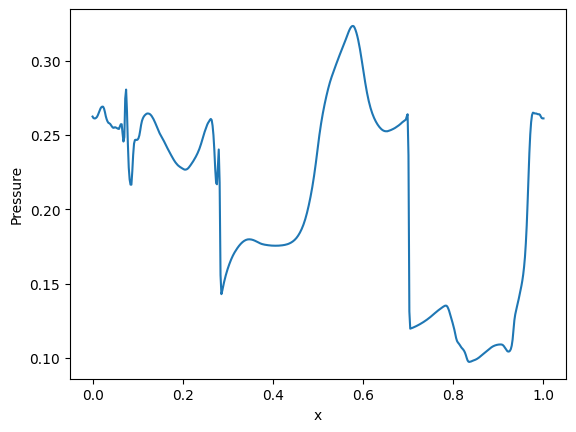

In [13]:
# plot the pressure at y = 0.4277
y = jnp.linspace(0, 1, num_cells)
x = jnp.linspace(0, 1, num_cells)
# find the index closest to 0.4277
y_index = jnp.argmin(jnp.abs(y - 0.3125))

plt.plot(x, final_state[0, :, y_index], label = "Pressure")

plt.xlabel("x")
plt.ylabel("Pressure")

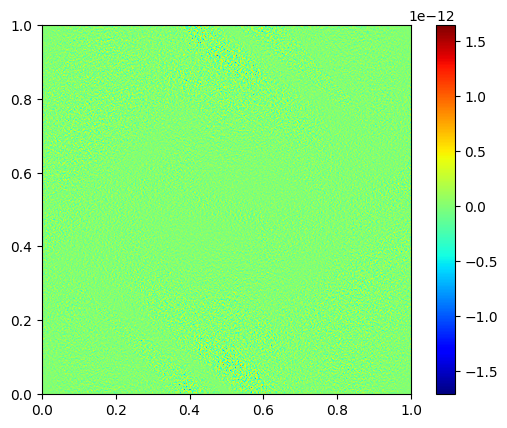

In [14]:
# divergence of the magnetic field
from jf1uids._physics_modules._mhd.mhd_maths import divergence2D


B_x = final_state[4, ...]
B_y = final_state[5, ...]
B_z = final_state[6, ...]

B = jnp.stack([B_x, B_y, B_z], axis=0)

divB = divergence2D(B, dx)

plt.imshow(divB.T, cmap = "jet", origin = "lower", extent=[0, 1, 0, 1])
plt.colorbar()